<h1><center><font color = "Red">Machine Learning - Building and Training Models</font></center></h1>

<h2><font color = "green">Objective</font></h2>

In this project we will try to predict the outcome of each new input match (Home_Team wins, Away_Team wins, Draw) and compare our results with the real probabilities estimated from the bookmaker. Our purpose, to achive higher accuracy than bookmaker's and thus to gain more profit. In order to do this, we will exclude from the dataset the bookmaker's odds and also the features from feature engineering and we will compare them all together at the end along with our predictions. So, we will make our predictions without the given bookmaker's odds as predictors!

<h3><font color = "orange">Load Necessary Libraries</font></h3>

In [72]:
# Sklearn necessary libraries for metrics, feature selection, pipelines and preprocessing steps
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline   

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

%matplotlib inline
# other libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shap
import mrmr
import os

# display all features
pd.set_option("display.max_columns", None)

# matplotlib settings
mpl.rc('axes', labelsize=15)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

# remove the top and right axis
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

warnings.filterwarnings(action="ignore")

<h3><font color = "orange">Load the Data</font></h3>

In [81]:
DATASETS_file = "../feature_engineering"
csv_file = "matches_prep.csv"

csv_file_path = os.path.join(DATASETS_file, csv_file)
matches_df = pd.read_csv(filepath_or_buffer=csv_file_path)

print(f"matches_df shape:\t{matches_df.shape}")
matches_df.head()

matches_df shape:	(6046, 37)


,winner,h_odd,d_odd,a_odd,ht_rank,ht_ls_rank,ht_days_ls_match,ht_points,ht_l_points,ht_l_wavg_goals,ht_goals_sf,ht_l_wavg_goals_sf,ht_draws,ht_win_streak,ht_loss_streak,ht_draw_streak,at_rank,at_ls_rank,at_days_ls_match,at_points,at_l_points,at_l_wavg_goals,at_goals_sf,at_l_wavg_goals_sf,at_draws,at_win_streak,at_loss_streak,at_draw_streak,ls_winner,h_implied_prob,d_implied_prob,a_implied_prob,bookmaker_total_prob,h_real_prob,d_real_prob,a_real_prob,real_total_prob
0,HOME_TEAM,1.68,4.22,4.96,8,8.0,4.0,58,3.000000,2.298375,39,0.691471,7,4,0,0,16,15.0,5.0,41,1.333333,2.012386,44,1.541537,14,1,0,0,AWAY_TEAM,0.595238,0.236967,0.201613,1.033818,0.575767,0.229215,0.195018,1.0
1,HOME_TEAM,6.99,4.92,1.45,11,17.0,4.0,52,1.333333,1.674424,45,1.528030,7,1,0,0,4,4.0,5.0,67,2.000000,1.448092,34,0.902502,10,1,0,0,DRAW,0.143062,0.203252,0.689655,1.035969,0.138094,0.196195,0.665710,1.0
2,AWAY_TEAM,2.49,3.48,2.91,18,-42.0,5.0,28,0.333333,0.794198,51,1.709559,13,0,0,1,12,13.0,4.0,42,2.000000,1.853031,62,1.460800,9,1,0,0,DRAW,0.401606,0.287356,0.343643,1.032605,0.388925,0.278283,0.332792,1.0
3,HOME_TEAM,1.55,4.78,5.59,9,-42.0,5.0,56,3.000000,2.418451,53,0.280725,5,3,0,0,19,-42.0,4.0,26,0.000000,1.043309,73,2.557325,11,0,3,0,AWAY_TEAM,0.645161,0.209205,0.178891,1.033257,0.624396,0.202471,0.173133,1.0
4,AWAY_TEAM,1.80,4.26,4.14,5,5.0,5.0,66,1.000000,1.450428,46,1.877408,6,0,1,0,7,6.0,4.0,59,1.000000,1.492041,43,1.471424,8,0,1,0,AWAY_TEAM,0.555556,0.234742,0.241546,1.031843,0.538411,0.227498,0.234092,1.0


<h3><font color = "orange">Data Preprocessing</font></h3>

In [82]:
# Convert the classes of "winner" feature to integers, HOME_TEAM = 2, AWAY_TEAM = 1, and DRAW = 0
matches_df["winner"] = np.where(matches_df["winner"] == "HOME_TEAM", 2, np.where(matches_df["winner"] == "AWAY_TEAM", 1, 0))

#  Declare predictors and target variable
X = matches_df.copy()
y = X.pop("winner")

# Convert the "ls_winner" object feature to dummies
X = pd.get_dummies(data=X)

# Split the dataset to training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
# Exlude the features bellow
exclude_features = ["h_odd", "d_odd", "a_odd", "h_implied_prob", "d_implied_prob", "a_implied_prob", 
                    "bookmaker_total_prob", "h_real_prob", "d_real_prob", "a_real_prob", "real_total_prob"]

# Keep the odds in seperate df
odds_and_probs = X_test.copy()[exclude_features]
odds_and_probs = pd.concat(objs=[odds_and_probs, y_test], axis=1).reset_index().drop("index", 1) # add and the target varible
odds_and_probs.head()

,h_odd,d_odd,a_odd,h_implied_prob,d_implied_prob,a_implied_prob,bookmaker_total_prob,h_real_prob,d_real_prob,a_real_prob,real_total_prob,winner
0,4.78,3.62,1.74,0.209205,0.276243,0.574713,1.060161,0.197333,0.260567,0.542100,1.0,0
1,1.78,3.38,4.87,0.561798,0.295858,0.205339,1.062995,0.528505,0.278325,0.193170,1.0,2
2,1.66,4.08,5.37,0.602410,0.245098,0.186220,1.033727,0.582755,0.237101,0.180144,1.0,1
3,5.15,4.05,1.68,0.194175,0.246914,0.595238,1.036326,0.187368,0.238258,0.574373,1.0,0
4,1.38,4.98,8.62,0.724638,0.200803,0.116009,1.041450,0.695797,0.192811,0.111392,1.0,2


In [84]:
# Now we don't need those features in our dataset, because with these features we will attempt to compare our predictions
X_train.drop(labels=exclude_features, axis=1, inplace=True)
X_test.drop(labels=exclude_features, axis=1, inplace=True)

In [85]:
print(X_train.shape)
X_train.head(3)

(4836, 28)


,ht_rank,ht_ls_rank,ht_days_ls_match,ht_points,ht_l_points,ht_l_wavg_goals,ht_goals_sf,ht_l_wavg_goals_sf,ht_draws,ht_win_streak,ht_loss_streak,ht_draw_streak,at_rank,at_ls_rank,at_days_ls_match,at_points,at_l_points,at_l_wavg_goals,at_goals_sf,at_l_wavg_goals_sf,at_draws,at_win_streak,at_loss_streak,at_draw_streak,ls_winner_-42,ls_winner_AWAY_TEAM,ls_winner_DRAW,ls_winner_HOME_TEAM
3948,17,15.0,4.0,18,1.000000,0.502138,34,1.409554,3,0,1,0,2,1.0,3.0,35,1.333333,1.988029,18,2.006386,5,0,0,1,0,0,0,1
1094,14,12.0,14.0,7,1.333333,1.000000,5,1.625000,1,0,1,0,9,9.0,14.0,6,2.000000,1.375000,5,1.500000,0,0,1,0,0,0,1,0
1121,17,15.0,8.0,0,0.000000,0.000000,2,2.000000,0,0,1,0,6,2.0,9.0,3,1.000000,2.000000,1,1.000000,0,1,0,0,0,0,0,1


In [86]:
# Using the MRMR technique will select the best 20 features and NOT the 20 best features 
# that we would take with the SelectKBest technique!! 
selected_features = mrmr.mrmr_classif(X=X_train, y=y_train, K=20)
X_train_mrmr = X_train.copy()[selected_features]
X_test_mrmr = X_test.copy()[selected_features]

100%|██████████| 20/20 [00:00<00:00, 22.16it/s]


<h2><font color = "green">Model Building and Training</font></h2>

<h3><font color = "orange">Select Best Scaler</font></h3>

In [114]:
def select_best_scaler(X_train, y_train, model, scalers, metrics, ndigits):
    """
    With this function we can compare different scalers and take the results 
    in a dataframe as an output.
    """
    scaler_scores = {"names": []}
    scaler_scores.update({metric.lower(): [] for metric in metrics })
    for scaler in scalers:
        # Create a pipeline to apply the model to the preproced data
        model_pipe = Pipeline(steps=[
                                    ("scaler", scaler), 
                                    ("classifier", model)])

        # Fit the model_pipe pipeline to the data
        model_pipe.fit(X=X_train, y=y_train)
        
        # Perform cross validation
        scaler_name = str(scaler).split("(")[0]
        scaler_scores["names"].append(scaler_name)
        for metric in metrics:
            metric = metric.lower()
            metric_scores = cross_val_score(estimator=model_pipe, X=X_train, y=y_train, scoring=f"{metric}", cv=10, n_jobs=-1)
            scaler_scores[metric].append(round(number=metric_scores.mean(), ndigits=ndigits))
            
    
    scaler_scores_df = pd.DataFrame(data=scaler_scores)
    return scaler_scores_df

In [115]:
 # We will use Logistic Regression as a first option
metrics = ["accuracy"]
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler()]
select_best_scaler(X_train_mrmr, y_train, LogisticRegression(), scalers, metrics, 6)

,names,accuracy
0,MinMaxScaler,0.564096
1,StandardScaler,0.562028
2,RobustScaler,0.562028


I will continue with MinMaxScaler.

<h3><font color = "orange">Select Best Model</font></h3>

In [116]:
## Check the performance with different models
def select_best_model(X_train, y_train, scaler, models, metrics, ndigits):
    """
    With this function we can compare different models and see take the results 
    in a dataframe as an output. Takes as input a list of models, and metrics.
    """
    model_scores = {"names": []}
    model_scores.update({metric.lower(): [] for metric in metrics })
    for model in models:
        # Create a pipeline to apply the model to the preproced data
        model_pipe = Pipeline(steps=[
                                    ("scaler", scaler),
                                    ("classifier", model)])

        # Fit the model_pipe pipeline to the data
        model_pipe.fit(X=X_train, y=y_train)
        
        # Perform cross validation
        model_name = str(model).split("(")[0]
        model_scores["names"].append(model_name)
        for metric in metrics:
            metric = metric.lower()
            metric_scores = cross_val_score(estimator=model_pipe, X=X_train, y=y_train, scoring=f"{metric}", cv=10, n_jobs=-1)
            model_scores[metric].append(round(number=metric_scores.mean(), ndigits=ndigits))
            
    model_scores_df = pd.DataFrame(data=model_scores).sort_values(by="accuracy", ascending=False)
    return model_scores_df 

In [117]:
models = [RandomForestClassifier(), KNeighborsClassifier(), LogisticRegression(), XGBClassifier(eval_metric="logloss"), LGBMClassifier()]
metrics = ["accuracy"]
select_best_model(X_train_mrmr, y_train, MinMaxScaler(), models, metrics, 5)

,names,accuracy
2,LogisticRegression,0.56410
0,RandomForestClassifier,0.53411
4,LGBMClassifier,0.52914
3,XGBClassifier,0.52088
1,KNeighborsClassifier,0.45347


<h3><font color = "orange">Hyperparameter Tuning</font></h3>

In [94]:
## Hyperparameter Tuning of the LogisticRegression model
model_pipe = Pipeline(steps=[
                        ("scaler", MinMaxScaler()),
                        ("classifier", LogisticRegression())])

hyperparameter_space = [{"classifier__solver": ["lbfgs", "newton-cg", "sag"],
                         "classifier__class_weight": ["balanced", None],
                         "classifier__penalty": ["l2", "none"], 
                         "classifier__C": [0.05, 0.1, 1, 2, 3, 4]},
                        {"classifier__penalty": ["l2", "l1", "none", "elasticnet"],
                         "classifier__class_weight": ["balanced", None], 
                         "classifier__C": [0.05, 0.1, 1, 2, 3, 4],
                         "classifier__solver": ["saga"]}]

grid_search = GridSearchCV(estimator=model_pipe, param_grid=hyperparameter_space, scoring="accuracy",
                           cv=5, n_jobs=-1, verbose=3, return_train_score=False)

grid_search.fit(X=X_train_mrmr, y=y_train)

# Take the results from the grid_search and display them as dataframe 
cv_res = grid_search.cv_results_

# Check the best parameters
best_parameters = grid_search.best_params_
print(f"Best parameters: {best_parameters}")

# See the best estimator
best_estimator = grid_search.best_estimator_
print(f"Best estimator:\t{best_estimator}")

scores = {"params": [], "accuracy": []}
for params, mean_test_score in zip(cv_res["params"], cv_res["mean_test_score"]):
    scores["params"].append(params)
    scores["accuracy"].append(mean_test_score)

scores_df = pd.DataFrame(data=scores)
scores_df.sort_values(by="accuracy", ascending=False).head()

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters: {'classifier__C': 3, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}
Best estimator:	Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression(C=3, solver='newton-cg'))])


,params,accuracy
55,"{'classifier__C': 3, 'classifier__class_weight...",0.562445
56,"{'classifier__C': 3, 'classifier__class_weight...",0.562445
108,"{'classifier__C': 3, 'classifier__class_weight...",0.562445
54,"{'classifier__C': 3, 'classifier__class_weight...",0.562239
93,"{'classifier__C': 1, 'classifier__class_weight...",0.562238


In [113]:
# Select and train the best model
model_pipe = Pipeline(steps=[
                        ("scaler", MinMaxScaler()),
                        ("classifier", best_estimator)])

model_pipe.fit(X=X_train_mrmr, y=y_train)

# Check accuracy
print(f"Accuracy on train set:\t  {round(number=model_pipe.score(X=X_train_mrmr, y=y_train), ndigits=4)}")
print(f"Accuracy on test set:\t  {round(number=model_pipe.score(X=X_test_mrmr, y=y_test), ndigits=4)}")

# Check accuracy with cross validation
train_scores = cross_val_score(estimator=model_pipe, X=X_train_mrmr, y=y_train, scoring="accuracy", cv=10)
test_scores = cross_val_score(estimator=model_pipe, X=X_test_mrmr, y=y_test, scoring="accuracy", cv=10)

print(f"CV Accuracy on train set: {round(number=train_scores.mean(), ndigits=4)}")
print(f"CV Accuracy on test set:  {round(number=test_scores.mean(), ndigits=4)}") 

Accuracy on train set:	  0.5637
Accuracy on test set:	  0.5603
CV Accuracy on train set: 0.5624
CV Accuracy on test set:  0.5645


We can see that the accuracy in the training and test same is almost the same, which means that our model doesn't overfit the data.

In [96]:
# Check the different classes
model_pipe.classes_

array([0, 1, 2])

In [97]:
# Predictions 
preds_proba = model_pipe.predict_proba(X_test_mrmr)
predictions_df = pd.DataFrame(data=preds_proba, columns=["d_our_prob", "a_our_prob", "h_our_prob"])

In [98]:
# Convert the integer classes of target feature "winner" back to categorical values
odds_and_probs["winner"] = np.where(odds_and_probs["winner"] == 2, "HOME_TEAM", np.where(odds_and_probs["winner"] == 1, "AWAY_TEAM", "DRAW"))
odds_and_probs.head()

,h_odd,d_odd,a_odd,h_implied_prob,d_implied_prob,a_implied_prob,bookmaker_total_prob,h_real_prob,d_real_prob,a_real_prob,real_total_prob,winner
0,4.78,3.62,1.74,0.209205,0.276243,0.574713,1.060161,0.197333,0.260567,0.542100,1.0,DRAW
1,1.78,3.38,4.87,0.561798,0.295858,0.205339,1.062995,0.528505,0.278325,0.193170,1.0,HOME_TEAM
2,1.66,4.08,5.37,0.602410,0.245098,0.186220,1.033727,0.582755,0.237101,0.180144,1.0,AWAY_TEAM
3,5.15,4.05,1.68,0.194175,0.246914,0.595238,1.036326,0.187368,0.238258,0.574373,1.0,DRAW
4,1.38,4.98,8.62,0.724638,0.200803,0.116009,1.041450,0.695797,0.192811,0.111392,1.0,HOME_TEAM


In [99]:
compare_df = pd.concat(objs=[odds_and_probs.reset_index(drop=True), predictions_df.reset_index(drop=True)], axis=1)
over_round = (compare_df["bookmaker_total_prob"] - 1) * 100
compare_df.insert(loc=7, column="over_round_percentage", value=over_round)
compare_df.head()

,h_odd,d_odd,a_odd,h_implied_prob,d_implied_prob,a_implied_prob,bookmaker_total_prob,over_round_percentage,h_real_prob,d_real_prob,a_real_prob,real_total_prob,winner,d_our_prob,a_our_prob,h_our_prob
0,4.78,3.62,1.74,0.209205,0.276243,0.574713,1.060161,6.016076,0.197333,0.260567,0.542100,1.0,DRAW,0.292530,0.561862,0.145608
1,1.78,3.38,4.87,0.561798,0.295858,0.205339,1.062995,6.299455,0.528505,0.278325,0.193170,1.0,HOME_TEAM,0.231052,0.135691,0.633256
2,1.66,4.08,5.37,0.602410,0.245098,0.186220,1.033727,3.372742,0.582755,0.237101,0.180144,1.0,AWAY_TEAM,0.290854,0.357497,0.351649
3,5.15,4.05,1.68,0.194175,0.246914,0.595238,1.036326,3.632643,0.187368,0.238258,0.574373,1.0,DRAW,0.340449,0.247526,0.412025
4,1.38,4.98,8.62,0.724638,0.200803,0.116009,1.041450,4.145017,0.695797,0.192811,0.111392,1.0,HOME_TEAM,0.243219,0.176850,0.579931


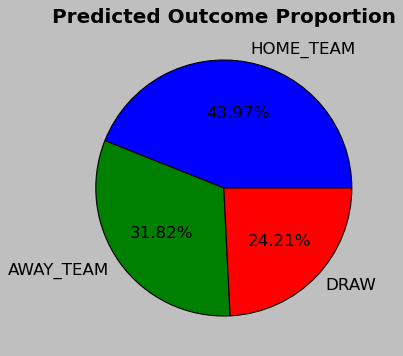

In [122]:
plt.style.use("classic")
plt.figure(figsize=(9, 5))
compare_df["winner"].value_counts().plot.pie(autopct='%1.2f%%', textprops={'color':"black", "fontsize": 15},
                                                                wedgeprops={"edgecolor": "black", "linewidth": 1, "linestyle": "solid", 
                                                                            "antialiased": True})
                                                                       
plt.title(label="Predicted Outcome Proportion", fontdict={"fontsize": 18, "weight": "bold", "color": "black"})
plt.ylabel("")
plt.show()

In [101]:
# Calculate the difference between our predicted probabilites and bookmaker's fair (not implied) probabilites
compare_df["h_prob_diff"] = compare_df["h_our_prob"] - compare_df["h_real_prob"]
compare_df["a_prob_diff"] = compare_df["a_our_prob"] - compare_df["a_real_prob"]
compare_df["d_prob_diff"] = compare_df["d_our_prob"] - compare_df["d_real_prob"]

# 1 for each positive difference and 0 for each negative difference
compare_df["h_wins"] = list(map(lambda x: 1 if x > 0 else 0, compare_df["h_prob_diff"]))
compare_df["a_wins"] = list(map(lambda x: 1 if x > 0 else 0, compare_df["a_prob_diff"]))
compare_df["d_wins"] = list(map(lambda x: 1 if x > 0 else 0, compare_df["d_prob_diff"]))

In [103]:
ht_df = compare_df.loc[compare_df["winner"] == "HOME_TEAM"]
at_df = compare_df.loc[compare_df["winner"] == "AWAY_TEAM"]
draw_df = compare_df.loc[compare_df["winner"] == "DRAW"]
ht_df.head()

,h_odd,d_odd,a_odd,h_implied_prob,d_implied_prob,a_implied_prob,bookmaker_total_prob,over_round_percentage,h_real_prob,d_real_prob,a_real_prob,real_total_prob,winner,d_our_prob,a_our_prob,h_our_prob,h_prob_diff,a_prob_diff,d_prob_diff,h_wins,a_wins,d_wins
1,1.78,3.38,4.87,0.561798,0.295858,0.205339,1.062995,6.299455,0.528505,0.278325,0.193170,1.0,HOME_TEAM,0.231052,0.135691,0.633256,0.104751,-0.057479,-0.047273,1,0,0
4,1.38,4.98,8.62,0.724638,0.200803,0.116009,1.041450,4.145017,0.695797,0.192811,0.111392,1.0,HOME_TEAM,0.243219,0.176850,0.579931,-0.115865,0.065458,0.050408,0,1,1
5,2.40,3.21,3.26,0.416667,0.311526,0.306748,1.034942,3.494161,0.402599,0.301009,0.296392,1.0,HOME_TEAM,0.361438,0.199310,0.439252,0.036653,-0.097083,0.060429,1,0,1
6,2.34,3.34,3.24,0.427350,0.299401,0.308642,1.035394,3.539360,0.412742,0.289167,0.298091,1.0,HOME_TEAM,0.296515,0.409501,0.293984,-0.118758,0.111410,0.007349,0,1,1
7,1.20,6.25,13.90,0.833333,0.160000,0.071942,1.065276,6.527578,0.782270,0.150196,0.067534,1.0,HOME_TEAM,0.193778,0.083281,0.722940,-0.059330,0.015747,0.043583,0,1,1


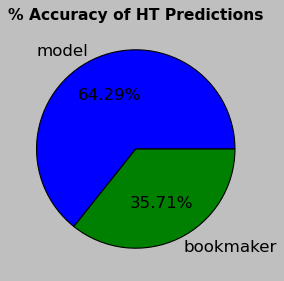

In [143]:
# Pie chart of percentage of correct predictions for the Home Team winning outcome
labels=["model", "bookmaker"]
plt.figure(figsize=(4, 4))
ht_df["h_wins"].value_counts().plot.pie(autopct='%1.2f%%', textprops={'color':"black", "fontsize": 15}, labels=labels,
                                                           wedgeprops={"edgecolor": "black", "linewidth": 1, "linestyle": "solid", 
                                                                       "antialiased": True})
                                                                       
plt.title(label="% Accuracy of HT Predictions", fontdict={"fontsize": 14, "weight": "bold", "color": "black"})
plt.ylabel("")
plt.savefig('books_read.png')
plt.show()

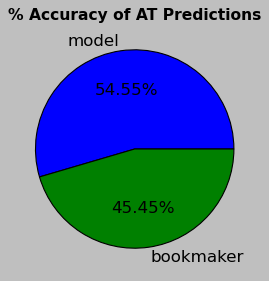

In [141]:
# Pie chart of percentage of correct predictions for the Away Team winning outcome
plt.figure(figsize=(4, 4))
at_df["h_wins"].value_counts().plot.pie(autopct='%1.2f%%', textprops={'color':"black", "fontsize": 15}, labels=labels,
                                             wedgeprops={"edgecolor": "black", "linewidth": 1, "linestyle": "solid", 
                                                         "antialiased": True})
plt.title(label="% Accuracy of AT Predictions", fontdict={"fontsize": 14, "weight": "bold", "color": "black"})
plt.ylabel("")
plt.show()

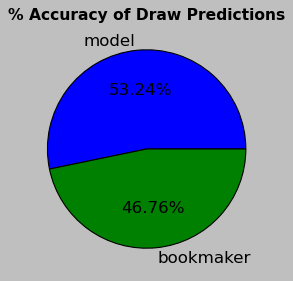

In [140]:
# Pie chart of percentage of correct predictions for Draw Outcome
plt.figure(figsize=(4, 4))
draw_df["h_wins"].value_counts().plot.pie(autopct='%1.2f%%', textprops={'color':"black", "fontsize": 15}, labels=labels,
                                             wedgeprops={"edgecolor": "black", "linewidth": 1, "linestyle": "solid", 
                                                         "antialiased": True})

plt.title(label="% Accuracy of Draw Predictions", fontdict={"fontsize": 14, "weight": "bold", "color": "black"})
plt.ylabel("")
plt.show()